# TensorFlow 2.0 alpha - Deep Convolutional Generative Adversarial Network (DCGANs)
### Generate Images of Handwritten Digits - MNIST dataset

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import glob 
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time

from tensorflow.keras import layers
from IPython import display

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Load & Prepare Dataset
#### Use the MNIST dataset to train the GENERATOR and the DISCRIMINATOR

In [3]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

# Normalize Images to [-1, 1]

train_images = (train_images - 127.5) / 127.5

BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and Shuffle data

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Create the Models
   ## 1. The Generator
#### Uses tf.keras.layers.Conv2DTranspose (unsampling) layers to produce Image from Seed (random noise)
#### A Dense layer takes Seed as Input - Unsample several times, until desired Image Size (28x28x1)
#### tf.keras.layers.LeakyReLU - activation for each layer, except Output layer

In [4]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)
    
    # None is the Batch_size
    
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same',
                                    use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
    
    return model
    

#### Use this (untrained) Generator - create an image

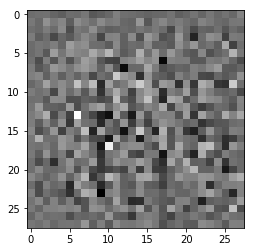

In [5]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

## 2. The Discriminator
#### A CNN-based Image Classifier

In [8]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28,28,1]))
    
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model

#### Use the (untrained) Discriminator - Classify images as Real or Fake
#### Model will output Positive values (Real) and Negative values (Fake)

In [9]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)

print(decision)

tf.Tensor([[-0.00127557]], shape=(1, 1), dtype=float32)


## Define Loss and Optimizers - for Both Models

In [11]:
# Method returns Helper Function - to compute cross entropy loss

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator Loss
#### Quantifies Discriminator's ability to judge Real from Fake - comparing real_predictions to an array of 1s, and fake_predictions to an array of 0s

In [26]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    
    return total_loss

### Generator Loss
#### Quantifies Generator's ability to trick the Discriminator - Good performance (producing fake images), would trick the Discriminator into classifying with 1s

In [27]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

#### The Optimizers for the 2 are different - The models are Trained separately

In [28]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)

discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Save Checkpoints

In [29]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                discriminator_optimizer = discriminator_optimizer,
                                generator = generator,
                                discriminator = discriminator)

## Define a Training Loop

In [30]:
EPOCHS = 35
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Reuse this seed overtime - so it is easier to visualize progress (animated GIF)

* Begins with Generator receiving Random Seed as input
* Seed is used to produce an Image
* Discriminator then classify Real images (from Training set) and Fake images (from Generator)
* Loss is calculated for Each model
* Gradients are used to update Each model

In [35]:
# tf.function - this annotation causes function to be 'Compiled'

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [36]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        for image_batch in dataset:
            train_step(image_batch)

# Produce images for the GIF as we go            
            
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                epoch + 1,
                                seed)

# Save model every 15 epochs        
        
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        
        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

# Generate after Final Epoch        
        
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

#### Generate and Save Images

In [39]:
def generate_and_save_images(model, epoch, test_input):

# Training is set to False here - so all layers run in Inference mode (batchnorm)
    
    predictions = model(test_input, training=False)
    
    fig = plt.figure(figsize=(4,4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

## Train the Model
#### Use train( ) - train Generator and Discriminator simultaneously
#### With GANs - important these models train at a similar rate - do Not overpower each other

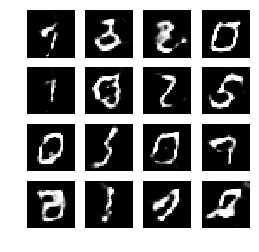

CPU times: user 13h 13min 23s, sys: 1h 51min 34s, total: 15h 4min 57s
Wall time: 5h 21min 26s


In [40]:
%%time
train(train_dataset, EPOCHS)

#### Restore the latest Checkpoint

In [41]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF

In [42]:
# Display a single image using the epoch number

def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

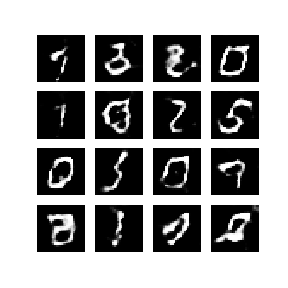

In [43]:
display_image(EPOCHS)

#### Use imageio - create animated gif - from images saved during training

In [44]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
    display.Image(filename=anim_file)